<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span></li></ul></div>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import gensim

!!! Если уже есть архивы с обучающей и тестовой выборкой, то пропустить до пункта "Exploratory Data Analysis and Metric"

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"cheremgena","key":"612804349bee7f5ec4bff977ed4ea76a"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
!kaggle datasets list

In [ ]:
# Copy the stackoverflow data set locally.
!kaggle competitions download -c language-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
SEED = 42

**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/bb11ace54b1a465e91b8c3f46a840ce0)**

# Exploratory Data Analysis and Metric

In [ ]:
#DATA_PATH = './data/competition_data'
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')

In [ ]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [ ]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [ ]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


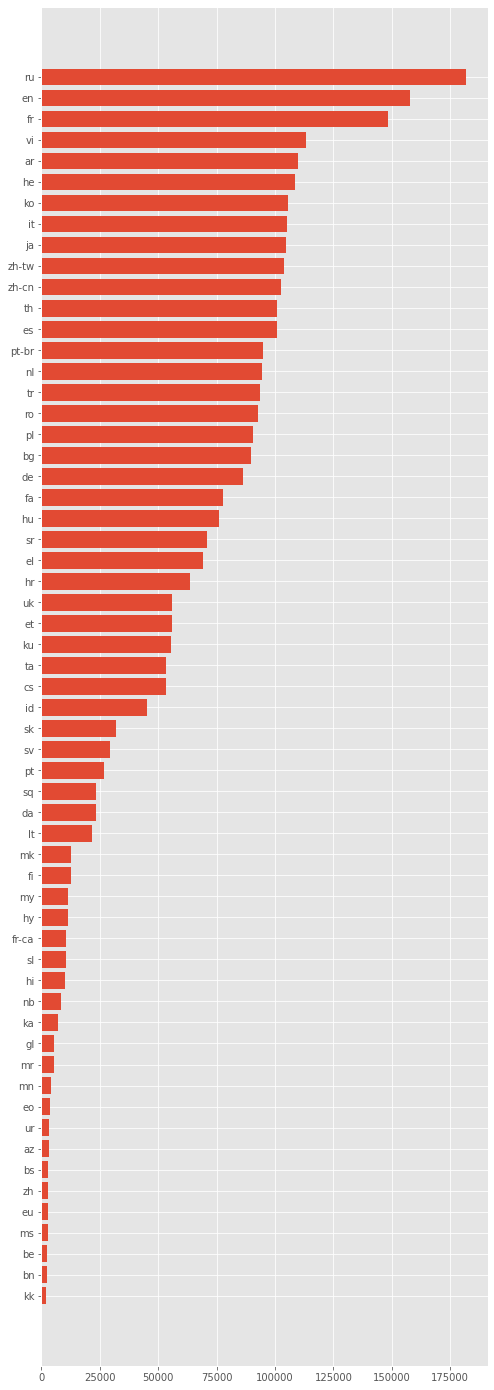

In [ ]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [ ]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

# Model

In [ ]:
x = train_df.values[:, 0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='log'))
])

In [ ]:
pipe.fit(x, y)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                ('model',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal',

In [ ]:
predictions = pipe.predict(x)

In [ ]:
balanced_accuracy_score(y, predictions)

0.4716591038583872

# Submit

In [ ]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [ ]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

In [ ]:
(
    test_df[['index', 'language']]
    .to_csv('sample_submission.csv', index=False)
)

In [ ]:
!head $DATA_PATH/sample_submission.csv

# Homework

- выбить хороший score на private leaderboard'е (8 баллов)
- совет: поищите ошибки в train-части датасета

In [ ]:
train_df.language.apply(lambda x: ('ja' in x) or ('zh' in x) or ('ko' in x))
#['ja', 'ko', 'zh']

0          False
1          False
2          False
3          False
4          False
           ...  
3159628     True
3159629    False
3159630    False
3159631    False
3159632    False
Name: language, Length: 3159633, dtype: bool

In [ ]:
little_sentenses = train_df.sentence.apply(lambda x: len(x))[(train_df.sentence.apply(lambda x: len(x)) < 3)].index
train_df.iloc[little_sentenses, :].language.value_counts()

zh-tw    208
zh-cn    191
ja        44
ko        30
zh        24
fr        18
nl         8
cs         5
he         4
vi         3
es         2
ar         2
hu         2
fa         1
hi         1
nb         1
pl         1
mk         1
ro         1
id         1
th         1
it         1
sr         1
sv         1
sl         1
pt-br      1
bg         1
hr         1
bn         1
ru         1
Name: language, dtype: int64

In [ ]:
n_lang = train_df.language.apply(lambda x: ('ja' in x) or ('zh' in x) or ('ko' in x))
little_sentenses_not_east = n_lang[n_lang == 1].index
little_sentenses_not_east

Int64Index([     12,      18,      19,      20,      21,      33,      36,
                 49,      58,      60,
            ...
            3159572, 3159573, 3159577, 3159589, 3159594, 3159616, 3159620,
            3159621, 3159625, 3159628],
           dtype='int64', length=420043)

In [ ]:
train_df.iloc[little_sentenses, :]

,sentence,language
13324,谢谢,zh-cn
16764,好啦,zh
16903,うん,ja
17066,开拍,zh-cn
46789,-,cs
...,...,...
3100234,さて,ja
3103575,谢谢,zh-cn
3117811,好,zh-tw
3123797,其實,zh-tw


##1 Поиск выбросов

###1.1 Русский язык

In [ ]:
import re

In [ ]:
rus = train_df[train_df.language == 'ru'].sentence

In [ ]:
# Тест регулярного выражения
display(rus[13])

s = re.findall('[^а-яёА-ЯЁ0-9\s,.:!?\"-=_+()[][%/\\@#$^&*|€<>;]?', rus[13])
if s:
    print(s.group())
else:
    print("сравнений не обнаружено")

'Ты знаешь , что это не гнев заставил моё сердце остановиться прежде чем молот упал .'

In [ ]:
outs_rus = rus.apply(lambda x: 1 if re.search('[^а-яёА-ЯЁ0-9\s,.:!?\"-=_+()[][%/\\@#$^&*|€<>;]?', x) else 0)
outs = rus[outs_rus == 1]

In [ ]:
outs.value_counts()

гэта што калі мы не яны як але ён каб дзякуй больш пра на вы                                                                                                                                                                                                                                                                                                                                                                                                                                    50000
що це тому ми чи дуже які щоб дякую якщо було вона від мене ось                                                                                                                                                                                                                                                                                                                                                                                                                                 25000
Надежда на милость , в мечта

In [ ]:
outs.shape

(96141,)

Тут видно, что 50 000 предложений сверху это белорусский язык, а вторые 25 000 - это украинский язык. Остальные содержат либо одно слово или букву на англ или другом языке, но в целом это русский язык. Также некоторые в списке выше содержат дефис или кавычки потому и попали в исключения.

###1.2 Англ язык

In [ ]:
english = train_df[train_df.language == 'en'].sentence

In [ ]:
english

24         Our Fred Astaires , our Gene Kellys our Michae...
103        Tell your daughters of this year , how we woke...
144        Nowadays , high school students can build robo...
170        A somatic cell , a body cell , was taken from ...
196        You know what , let them use their mobile phon...
                                 ...                        
3159540    So this is a story of Napoleon III in the mid-...
3159556    The first thing I want to do is start with a g...
3159567    We &apos;re ethically precluded from even usin...
3159606               Well , I became a tapestry historian .
3159611    I traveled with the Arhuacos , and the wonderf...
Name: sentence, Length: 157655, dtype: object

In [ ]:
outs_eng = english.apply(lambda x: 1 if re.search('[^a-zA-Z0-9\s,.:!?\"-=_+()[][%/\\@#$^&*|€<>;]?', x) else 0)
outs_en = english[outs_eng == 1]

In [ ]:
outs_en.value_counts()

що це тому ми чи дуже які щоб дякую якщо було вона від мене ось                                                                                                                                                                  25000
&apos;Cause all I ever had — redemption songs .                                                                                                                                                                                      4
Here &apos;s a passage — it &apos;s very much what he said , anyway : &quot; &quot; If there was no God we would all be accidents , the result of astronomical random chance in the Universe .                                       1
And the tea is sitting in this stuff to the right — the tea is to the right of this line .                                                                                                                                           1
First question : If I want to ask them to call up — because they do hear the

Здесь проскочило тоже предложение на украинском языке на 25 000 обьектов, остальные сдержат только дефисы. Видимо это предложение есть во многих языках как выброс, мб и то предложение на белорусском тоже в нескольких языках есть.

###1.3 Французский

In [ ]:
franch = train_df[train_df.language == 'fr'].sentence
outs_fr = franch.apply(lambda x: 1 if re.search('[^a-zA-Z0-9\s,.:!?\"-=_+()[][%/\\@#$^&*|€<>;]?', x) else 0)
outs_fr = franch[outs_fr == 1]
outs_fr.value_counts()

это что мы не как на вы они но из то он так для аплодисменты                                                                                                                                                                                                 50000
Voilà .                                                                                                                                                                                                                                                          6
Qu&apos; est-ce que ça veut dire ?                                                                                                                                                                                                                               6
C&apos; est inévitable .                                                                                                                                                                                                       

In [ ]:
train_df[train_df.language == 'fr'].sentence.value_counts()

это что мы не как на вы они но из то он так для аплодисменты                                                                                                                                                                    50000
( Applaudissements )                                                                                                                                                                                                              544
Merci .                                                                                                                                                                                                                           346
Merci beaucoup .                                                                                                                                                                                                                  180
Pourquoi ?                                                                      

Опять есть выброс на 50 000, видимо такая картина будет наблюдаться сразу у нескольких языков.

### 1.4 Прочие языки

In [ ]:
for lang in train_df.language.unique():
  print('\n', lang)
  print(train_df[train_df.language == lang].sentence.value_counts()[:5])


 fr
это что мы не как на вы они но из то он так для аплодисменты    50000
( Applaudissements )                                              544
Merci .                                                           346
Merci beaucoup .                                                  180
Pourquoi ?                                                         31
Name: sentence, dtype: int64

 cs
( Potlesk )     256
Děkuji .        121
Děkuji vám .     88
( potlesk )      58
Proč ?           18
Name: sentence, dtype: int64

 sv
( Applåder )        205
Tack .               87
Tack så mycket .     64
Varför ?             12
Tack !               12
Name: sentence, dtype: int64

 ar
( تصفيق )           643
شكرا لكم .           91
شكراً لكم .          61
شكرا جزيلا لكم .     38
شكراً لكم            38
Name: sentence, dtype: int64

 hr
( Pljesak )         424
Hvala vam .         177
Hvala .              73
Hvala vam puno .     41
Puno vam hvala .     36
Name: sentence, dtype: int64

 id
( Tepuk tangan 

In [ ]:
train_df[train_df.language == 'ur'].sentence.value_counts()

( تالیاں )                                                                                                                                                                                                                        29
شکریہ ۔                                                                                                                                                                                                                            5
شکریہ                                                                                                                                                                                                                              3
بہت بہت شکریہ -                                                                                                                                                                                                                    2
نہیں ، وہ بھی نہیں ۔                                                                

In [ ]:
train_df[(train_df.language == 'ur') & (train_df.sentence == 'شکریہ ۔')]

,sentence,language
631113,شکریہ ۔,ur
1896826,شکریہ ۔,ur
2207585,شکریہ ۔,ur
2243004,شکریہ ۔,ur
2900474,شکریہ ۔,ur


Стоит замететь, что довольно часто во многих языках встречается конструкция '&quos' и '&apos'. Скорее всего, они заменяют какие-то знаки пунктуации, поэтому их нужно удалить. 

##2 Подготовка данных и модель

In [ ]:
# удаление выбросов на 50к и 25к
list_inf_for_del = np.array([])
for lang in ['ru', 'th', 'ta', 'et', 'ku', 'vi', 'en', 'fr']:
  if lang in ['ru', 'th']:
    del_v = list(train_df[train_df.language == 'ru'].sentence.value_counts().index)[:2]
    list_inf_for_del = np.hstack([list_inf_for_del, 
                                  np.array(train_df[(train_df.language == 'ru') & 
                                                    ((train_df.sentence == del_v[0]) | 
                                                          (train_df.sentence == del_v[1]))].index)])
  else:
    del_v = list(train_df[train_df.language == lang].sentence.value_counts().index)[0]
    list_inf_for_del = np.hstack([list_inf_for_del, train_df[(train_df.language == lang) & (train_df.sentence == del_v)].index])

In [ ]:
train_df.iloc[list_inf_for_del, :].sentence.value_counts()

гэта што калі мы не яны як але ён каб дзякуй больш пра на вы          100000
що це тому ми чи дуже які щоб дякую якщо було вона від мене ось        75000
the and of it that you to apos we this is in they so are               50000
бұл мен біз бір үшін ол деп және емес бар керек бірақ олар қол осы     50000
это что мы не как на вы они но из то он так для аплодисменты           50000
що це ми не як на вони та але ви до про він оплески коли               50000
笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說                      25000
Name: sentence, dtype: int64

In [ ]:
train_df_not_outs = train_df.drop(list_inf_for_del, axis = 0)

In [ ]:
train_df_not_outs

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
...,...,...
3159628,そんな所で捕まっている片手は 70億の人々と繫がる命綱なのです,ja
3159629,Първоначално се опитах да направя думите &quot...,bg
3159630,Ho appreso che ha a che fare con l&apos; atten...,it
3159631,E os edifícios não se limitam a apenas evocar ...,pt-br


In [ ]:
train_df_not_outs[train_df_not_outs.language == 'fr'].sentence.value_counts()

( Applaudissements )                                                                                                                                                                                                                                                                                                          544
Merci .                                                                                                                                                                                                                                                                                                                       346
Merci beaucoup .                                                                                                                                                                                                                                                                                                              180
Pourquoi ?                        

In [ ]:
x = train_df_not_outs.values[:, 0]
label_encoder = LabelEncoder().fit(train_df_not_outs.values[:, 1])
y = label_encoder.transform(train_df_not_outs.values[:, 1])

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=('apos', 'quot'), 
                                   min_df = 5, max_df = 0.99)),
    ('model', SGDClassifier(random_state=SEED, loss='log', 
                            alpha = 1e-7,
                            class_weight = 'balanced', 
                            n_jobs=-1, 
                            average = True))])

##3 Тренировка по батчам и по всей выборке

In [ ]:
# для генерации батчей
def batch_generator(X, y, batch_size = 100000):
  np.random.seed(50)
  perm = np.random.permutation(X.shape[0])
  n_batches = X.shape[0]//batch_size

  for i in range(n_batches):
    if i < n_batches-1:
      X_ = X[perm[i*batch_size:(i+1)*batch_size]]
      y_ = y[perm[i*batch_size:(i+1)*batch_size]]
    else:
      X_ = X[perm[i*batch_size:]]
      y_ = y[perm[i*batch_size:]]

    yield X_, y_

In [ ]:
# для обучения по батчам
def train(X_train, y_train, batch_size, model):
  train_loss = []

  for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
    model.fit(X_batch, y_batch)
    preds = model.predict(X_batch)

    metr = balanced_accuracy_score(y_batch, preds)
    train_loss.append(metr)
    print(metr)
  return train_loss

In [ ]:
lo = train(x, y, 300000, pipe)

In [ ]:
pipe.fit(x[:2500000], y[:2500000])

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.99, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=('apos', 'quot'),
                                 strip_accents=None, sublinear_tf=Fals...
                ('model',
                 SGDClassifier(alpha=1e-07, average=True,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                            

In [ ]:
predictions = pipe.predict(x[2500000:])
balanced_accuracy_score(y[2500000:], predictions)

0.883256388472344

##4 Выгрузка на каггл

In [ ]:
test_df.sentence.value_counts()

( Aplausos )                                                                                                                         1367
( Applaus )                                                                                                                          1150
( Applause )                                                                                                                          826
( Applaudissements )                                                                                                                  674
( تصفيق )                                                                                                                             653
                                                                                                                                     ... 
Baby &apos; s reageren op niet veel .                                                                                                   1
We can load up all the neurons , e

In [ ]:
x_test = test_df.sentence.values

In [ ]:
y_kag = pipe.predict(x_test)

In [ ]:
test_df['language'] = label_encoder.classes_[y_kag]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,zh-tw


In [ ]:
(
    test_df[['index', 'language']]
    .to_csv('sample_submission.csv', index=False)
)